In [1]:
import numpy as np
import pandas as pd

In [2]:
df_csv=pd.read_csv('Provo_Corpus-Eyetracking_Data(sub1-10).csv')

In [3]:
#构造一个只含有我们关心字段的DataFrame
#Text_ID用来划分训练集和测试集。Text，Word_Length，IA_SKIP是特征。Participant_ID是监督学习的标签。
df=pd.DataFrame(columns=['Text_ID','Text','Word_Length','IA_SKIP','Participant_ID'])
sub_id=['Sub01','Sub02','Sub03','Sub04','Sub05','Sub06','Sub07','Sub08','Sub09','Sub10']
for i in sub_id:
    for j in range(1,56): #句子1-55
        df_csv_a_text=df_csv[(df_csv['Participant_ID']==i) & (df_csv['Text_ID']==j)]
        sr_Word=df_csv_a_text['Word'] #得到一个Series
        sr_Word_Length=df_csv_a_text['Word_Length']
        sr_IA_SKIP=df_csv_a_text['IA_SKIP']
        #str=sr_word.str.cat(sep=' ',na_rep=' ') 
        #把Series中的元素连接成一个str。以sep参数为间隔。NA值的处理按照na_sep参数，这里NA值用空格代替，不写的话，NA值连接不上，会被忽略
        list_Word=sr_Word.fillna(' ').astype(np.string_).tolist() #先处理NA值，再指定数据类型，再转成list。
        list_Word_Length=sr_Word_Length.fillna(0).astype('int').tolist() #前一行强制转成string是因为有数字存在，而list中str和数字可并存
        list_IA_SKIP=sr_IA_SKIP.tolist() #IA_SKIP中不存在NA
        s=pd.Series([j,list_Word,list_Word_Length,list_IA_SKIP,int(i.replace('Sub',''))-1],
                    index=['Text_ID','Text','Word_Length','IA_SKIP','Participant_ID'])
        #构造一个临时Series，包含的数据是读者i阅读句子j时的眼动数据。
        #把标签做个处理，Sub1-10换成了阿拉伯数字0-9。为了神经网络的需要。
        df=df.append(s.to_frame().T)
        #Series专成DataFrame之后，Series的index是行名，需要转置，成为列名，然后再append上去
        
df_train=df[df['Text_ID']<=45] #1-45(共45)句做训练数据
df_test=df[df['Text_ID']>45] #46-55(共10)句做测试数据
y_train=df_train['Participant_ID'].tolist()
y_test=df_test['Participant_ID'].tolist() #把标签先提取出来
df.head(5) #df的前5行

,Text_ID,Text,Word_Length,IA_SKIP,Participant_ID
0,1,"[b'are', b'now', b'rumblings', b'that', b'Appl...","[3, 3, 9, 4, 5, 5, 4, 6, 3, 5, 5, 5, 6, 3, 7, ...","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",0
0,2,"[b'days', b'later,', b'the', b'British', b'ast...","[4, 5, 3, 7, 10, 7, 0, 3, 9, 3, 11, 7, 5, 7, 3...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
0,3,"[b'agree', b'that', b""California's"", b'""three'...","[5, 4, 12, 5, 7, 3, 6, 3, 3, 4, 2, 1, 9, 8, 3,...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0
0,4,"[b'was', b'in', b'a', b'bad', b'temper,', b'fo...","[3, 2, 1, 3, 6, 3, 3, 3, 6, 3, 9, 8, 2, 3, 7, ...","[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, ...",0
0,5,"[b'Darling', b'quivered', b'and', b'went', b't...","[7, 8, 3, 4, 2, 3, 6, 2, 3, 8, 8, 3, 6, 3, 3, ...","[0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, ...",0


In [4]:
#下面开始对Text进行Token的准备工作，即把单词转成字典中的数字
#需要确定两个参数：字典的大小，转换后的序列最大长度
sr_all_word=df_csv[(df_csv['Participant_ID']=='Sub01')]['Word'] #从原始csv中得到Sub01读的所有word，放到Series中
sr_all_word=sr_all_word.str.strip() #把Series中的每个元素进行strip操作
sr_all_word=sr_all_word.fillna(' ') #用空格填充NA值
print(len(sr_all_word)) #阅读的单词总数
print(len(sr_all_word.unique())) #去重之后的单词数。字典的大小据此设为1500(>1318)

list_text=[] #所有text
len_text=[] #所有text的长度
for i in range(1,56):
    ser_text=df['Text'][(df['Participant_ID']==1) & (df['Text_ID']==i)] #切片操作得到的是一个只含一个元素的Series
    str_text=ser_text[0] #取第0个元素，得到字符串
    len_text.append(len(str_text))
 #   sentence=" ".join(text)
    list_text.append(str_text)

print(max(len_text)) #据此设置pad sequences的maxlen为60

2743
1318
60


In [5]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer


Using TensorFlow backend.


In [6]:
token = Tokenizer(num_words=1500)
token.fit_on_texts(list_text)
print(token.document_count) #一共读了55个句子
#print(token.word_index) #这是一个字典 {b'the': 1, b'to': 2, b'a': 3, b'and': 4, b'of': 5,...}

55


In [7]:
x_train_seq_Text=token.texts_to_sequences(df_train['Text']) #把单词序列转换成数字序列，得到的是一个list
x_test_seq_Text=token.texts_to_sequences(df_test['Text'])

x_train_seq_IA_SKIP=df_train['IA_SKIP'] #得到的是一个Series
x_test_seq_IA_SKIP=df_test['IA_SKIP']

x_train_seq_Word_Length=df_train['Word_Length'] #得到的是一个Series
x_test_seq_Word_Length=df_test['Word_Length']

x_train_Text = sequence.pad_sequences(x_train_seq_Text, maxlen=60) #补齐长度为60，左补齐，缺省0，得到是一个numpy.ndarray型
x_test_Text = sequence.pad_sequences(x_test_seq_Text, maxlen=60)

x_train_IA_SKIP = sequence.pad_sequences(x_train_seq_IA_SKIP, maxlen=60,value=1) #补齐长度为60，左补齐，缺省1，即SKIP
x_test_IA_SKIP = sequence.pad_sequences(x_test_seq_IA_SKIP, maxlen=60,value=1)

x_train_Word_Length = sequence.pad_sequences(x_train_seq_Word_Length, maxlen=60) #补齐长度为60，左补齐，缺省0
x_test_Word_Length = sequence.pad_sequences(x_test_seq_Word_Length, maxlen=60)

print(x_train_seq_Text[0]) #因为是list，所以可以直接索引
print(x_train_Text[0]) #因为是numpy.ndarray，所以可以直接索引型

#下面这个Series切片很讲究，Series的index全部相同就会出现这样的问题。
#要达到目的应该这样写 print(x_train_seq_IA_SKIP[0:1][0]) 
#若写成x_train_seq_IA_SKIP[0]表示切片Series中index值为0的所有元素，即Series本身。因为我们没有为Series指定index，故index全部为0
#用x_train_seq_IA_SKIP[0:1]表示只切[0:1]，这样只有一个index为0的元素，再[0]就是元素本身
#所以，虽然用x_train_seq_IA_SKIP[0:1][0]也能解决，但太麻烦，最后用iloc解决
print(x_train_seq_IA_SKIP.iloc[0]) #iloc按行号和列号索引，.loc按行和列的标签值索引
print(x_train_IA_SKIP[0])

print(x_train_seq_Word_Length.iloc[0]) #iloc按行号和列号索引，.loc按行和列的标签值索引
print(x_train_Word_Length[0])

[22, 132, 292, 8, 293, 91, 133, 294, 1, 134, 92, 295, 135, 1, 296, 10, 297, 35, 298, 136, 1, 92, 93, 25, 3, 299, 18, 300, 13, 49, 30, 137, 12, 2, 301, 1, 302, 16, 138, 303, 49, 30, 304, 31, 1, 92, 305, 2, 306, 1, 307, 4, 308, 5, 3, 309, 6]
[  0   0   0  22 132 292   8 293  91 133 294   1 134  92 295 135   1 296
  10 297  35 298 136   1  92  93  25   3 299  18 300  13  49  30 137  12
   2 301   1 302  16 138 303  49  30 304  31   1  92 305   2 306   1 307
   4 308   5   3 309   6]
[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0]
[1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1
 0 1 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0]
[3, 3, 9, 4, 5, 5, 4, 6, 3, 5, 5, 5, 6, 3, 7, 2, 11, 3, 9, 7, 3, 5, 7, 4, 1, 10, 2, 7, 3, 3, 3, 3, 2, 2, 7, 3, 5, 2, 4, 5, 3, 3, 6, 2, 3, 5, 4, 2, 4, 3, 6, 3, 5, 2, 1, 4, 0]
[ 0  0  0  3  3  9  4  5  5  4  6  3  5  5  5 

In [8]:
from keras.utils import np_utils
y_TrainOneHot = np_utils.to_categorical(y_train) #把标签换成one_hot，这里的标签必须是0开始的整数。得到的是一个numpy.ndarray
y_TestOneHot = np_utils.to_categorical(y_test)
y_TrainOneHot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [9]:
from keras.layers import Input, Embedding, LSTM, Dense,concatenate,Convolution1D,Conv1D,MaxPool1D,Dropout
from keras.models import Model
from keras import regularizers

Text_input = Input(shape=(60,), name='text_input')
x = Embedding(output_dim=32, input_dim=1500, input_length=60)(Text_input)
x = Conv1D(32, kernel_size=3,activation='relu')(x)
x = MaxPool1D(pool_size=2)(x)

lstm_out = LSTM(32)(x) #32个节点的LSTM
# Embedding 层将输入序列编码为一个稠密向量的序列，每个向量维度为 512，input_dim是词汇表大小，input_length是每一句的单词数

IA_SKIP_input = Input(shape=(60,), name='ia_skip_input')
Word_Length_input = Input(shape=(60,), name='world_length_input')
x =concatenate([lstm_out, IA_SKIP_input,Word_Length_input])
#将辅助输入数据与 LSTM 层的输出连接起来，输入到模型中

x=Dropout(0.2)(x)

x = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
#x = Dense(32, activation='relu')(x)
#x = Dense(32, activation='relu')(x)
# 堆叠多个全连接网络层

main_output = Dense(10, activation='softmax', name='main_output',kernel_regularizer=regularizers.l2(0.01))(x)
#输出是softmax，10个节点，对应10个分类标签值

model = Model(inputs=[Text_input, IA_SKIP_input,Word_Length_input], outputs=main_output)
#定义一个具有两个输入和一个输出的模型

model.compile(loss='binary_crossentropy',
              optimizer='RMSprop', #RMSprop该优化器通常是面对递归神经网络时的一个良好选择
             #loss_weights={'main_output': 1},
              metrics=['accuracy'])
#现在编译模型

model.summary()
#打印模型概要

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 32)       48000       text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 58, 32)       3104        embedding_1[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxP

In [10]:
train_history=model.fit([x_train_Text, x_train_IA_SKIP,x_train_Word_Length],
          y_TrainOneHot, validation_split=0.2,
          epochs=8, batch_size=16)

Instructions for updating:
Use tf.cast instead.
Train on 360 samples, validate on 90 samples
Epoch 1/8
360/360 [==============================] - 2s 6ms/step - loss: 1.1141 - acc: 0.8617 - val_loss: 1.0199 - val_acc: 0.8967
Epoch 2/8
360/360 [==============================] - 1s 2ms/step - loss: 0.8550 - acc: 0.8939 - val_loss: 0.9228 - val_acc: 0.8978
Epoch 3/8
360/360 [==============================] - 1s 2ms/step - loss: 0.7523 - acc: 0.8983 - val_loss: 0.8283 - val_acc: 0.9000
Epoch 4/8
360/360 [==============================] - 1s 2ms/step - loss: 0.6653 - acc: 0.8992 - val_loss: 0.7428 - val_acc: 0.9000
Epoch 5/8
360/360 [==============================] - 1s 2ms/step - loss: 0.5963 - acc: 0.9000 - val_loss: 0.6987 - val_acc: 0.9000
Epoch 6/8
360/360 [==============================] - 1s 2ms/step - loss: 0.5313 - acc: 0.9000 - val_loss: 0.6752 - val_acc: 0.9000
Epoch 7/8
360/360 [==============================] - 1s 2ms/step - loss: 0.4837 - acc: 0.9000 - val_loss: 0.6566 - val_ac

In [11]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'])
    plt.show()

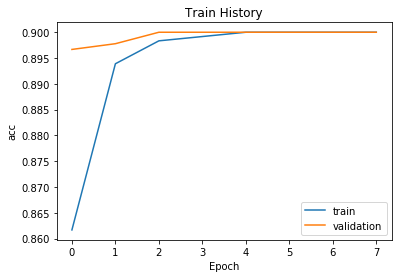

In [12]:
show_train_history(train_history,'acc','val_acc')

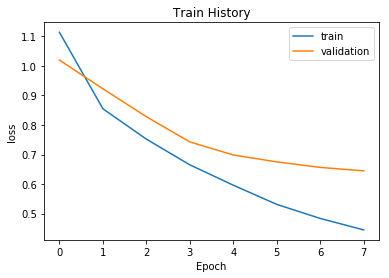

In [13]:
show_train_history(train_history,'loss','val_loss')

In [14]:
scores=model.evaluate([x_test_Text, x_test_IA_SKIP,x_test_Word_Length],y_TestOneHot)
scores[1]

100/100 [==============================] - 0s 300us/step


0.8999999761581421

In [15]:
model.save('model.h5')

#from keras.utils import plot_model
#plot_model(model, to_file='model.png')